# Irradiance interval generation example

<table>
  <tr>
    <td><img src="https://raw.githubusercontent.com/AlexandreHugoMathieu/pvfault_detection_solar_academy/refs/heads/master/notebooks/logos/CSTB_logo.jpg" width="200" />
    <td><img src="https://raw.githubusercontent.com/AlexandreHugoMathieu/pvfault_detection_solar_academy/refs/heads/master/notebooks/logos/Heliocity_logo.png" width="200" /> 
    <td><img src="https://raw.githubusercontent.com/AlexandreHugoMathieu/pvfault_detection_solar_academy/refs/heads/master/notebooks/logos/USMB_logo_horizontal.png" width="200" />
  </tr>
</table>

<sub>Author: Alexandre MATHIEU, Phd Student, in collaboration Heliocity / CSTB / USMB (LOCIE). </sub>
<sub>Phd thesis: Methodology development to guarantee building photovoltaic systems' performance including failure modelling</sub>

This notebook enables to generate Monte Carlo simulations to generate 95%-interval for the horizontal & Plane Of Array (POA) components.

It illustrates the section 2.2.2 of Alexandre MATHIEU's PhD manuscript (2025).

In [1]:
# Packages..
import matplotlib.pyplot as plt
import os
import pandas as pd

from pathlib import Path

# Change the directory path to import functions from local modules
if not 'workbookDir' in globals():
    workbookDir = Path(os.getcwd()).parent
print('Work directory: ' + str(workbookDir))
os.chdir(workbookDir)

# Bunch of local scripts
from irr_uncertainty.config import DATA_PATH
from irr_uncertainty.data.irr_data import cams_data_pvlib
from irr_uncertainty.data.solar_data import solarpos
from irr_uncertainty.models.uncertainty_model import irrh_scenarios, transpo_scenarios
from irr_uncertainty.utils import q_plot, blue

Work directory: C:\Users\oOo\Desktop\Work\code\irr_uncertainty


## I. Horizontal plane illustrations

Fetch data and generate 95%-intervals from Monte Carlo simulations.

In [2]:
start = pd.to_datetime("20220812").tz_localize("UTC")
end = pd.to_datetime("20220816").tz_localize("UTC")
n_scenarios = 1000

# Grenoble, FRANCE
lat = 45.16
long = 5.72
alt = 212

# Fetch CAMS data
sat_data = cams_data_pvlib(lat, long, alt, start, end)

# Get hourly solar position and compensate for the end-of time integration
solar_position = solarpos(sat_data.index, lat, long, alt).shift(-1)  

# Compute the MC simulations
ghi_scns, dhi_scns, bhi_scns = irrh_scenarios(lat, long, alt, solar_position, sat_data["ghi"],
                                              n_scenarios=n_scenarios)

Horizontal Irradiation scenarios: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:10<00:00, 14.18it/s]


Plot it !

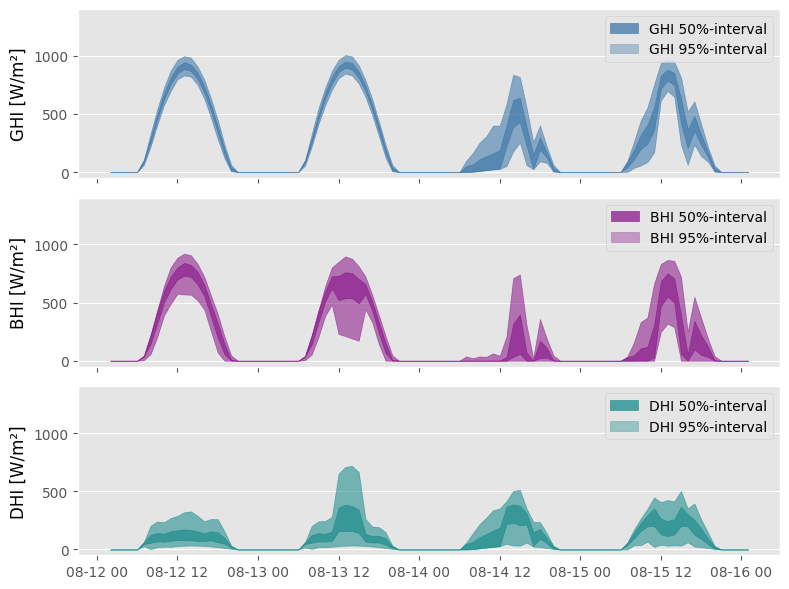

In [3]:
# GHI, BHI, DHI, POAgrd
plt.style.use("ggplot")
quantiles = [0.5, 0.95]
fig, axes = plt.subplots(3, 1, figsize=(8, 6), sharex=True)

# GHI
axes[0] = q_plot(ghi_scns.loc[:], quantiles=quantiles, color=blue, ax=axes[0], label="GHI")
alpha = 1 / len(quantiles)
axes[0].set_ylabel("GHI [W/m²]", color="black")
axes[0].set_ylim([-50, 1400])
axes[0].get_yaxis().set_ticks([0, 500, 1000])
axes[0].grid(axis="x")

# BHI
axes[1] = q_plot(bhi_scns.loc[:], quantiles=quantiles, color="purple", ax=axes[1], label="BHI")
axes[1].set_ylabel("BHI [W/m²]", color="black")
axes[1].set_ylim([-50, 1400])
axes[1].get_yaxis().set_ticks([0, 500, 1000])
axes[1].grid(axis="x")

# DHI
axes[2] = q_plot(dhi_scns.loc[:], quantiles=quantiles, color="teal", ax=axes[2], label="DHI")

axes[2].set_ylabel("DHI [W/m²]", color="black")
axes[2].set_ylim([-50, 1400])
axes[2].get_yaxis().set_ticks([0, 500, 1000])
axes[2].grid(axis="x")

plt.tight_layout()
plt.savefig(DATA_PATH / "irr_data" / "images" / f"illustration_h_all_quantiles.png")

## II. POA illustrations

Generate 95%-intervals for the plane of array from Monte Carlo simulations based on the horizontal simulations.

In [4]:
tilt = 25

# Generate Monte Carlo simulations
poa_scns_s, _, _, _ = \
    transpo_scenarios(tilt, 180, lat, long, alt, solar_position, ghi_scns, dhi_scns, n_scenarios=n_scenarios)
poa_scns_e, _, _, _ = \
    transpo_scenarios(tilt, 90, lat, long, alt, solar_position, ghi_scns, dhi_scns, n_scenarios=n_scenarios)
poa_scns_w, _, _, _ = \
    transpo_scenarios(tilt, 270, lat, long, alt, solar_position, ghi_scns, dhi_scns, n_scenarios=n_scenarios)

POA Irradiance simulations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:22<00:00, 44.38it/s]


Plot it !

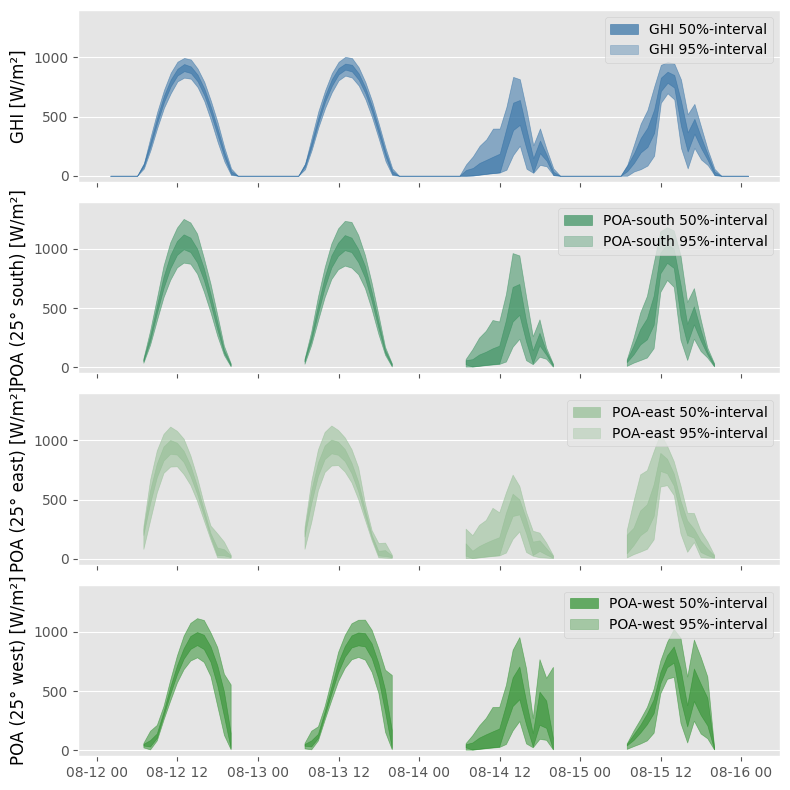

In [5]:
# GHI, POAgrd
quantiles = [0.5, 0.95]
fig, axes = plt.subplots(4, 1, figsize=(8, 8), sharex=True, sharey=True)

# GHI
axes[0] = q_plot(ghi_scns.loc[:], quantiles=quantiles, color=blue, ax=axes[0], label="GHI")
axes[0].set_ylabel("GHI [W/m²]", color="black")
axes[0].set_ylim([-50, 1400])
axes[0].get_yaxis().set_ticks([0, 500, 1000])
axes[0].grid(axis="x")

# POA-s
axes[1] = q_plot(poa_scns_s.loc[:], quantiles=quantiles, color="seagreen", ax=axes[1], label="POA-south")
axes[1].set_ylabel("POA (25° south) [W/m²]", color="black")
axes[1].grid(axis="x")

# POA-e
axes[2] = q_plot(poa_scns_e.loc[:], quantiles=quantiles, color="darkseagreen", ax=axes[2], label="POA-east")
axes[2].set_ylabel("POA (25° east) [W/m²]", color="black")
axes[2].grid(axis="x")

# POA-w
axes[3] = q_plot(poa_scns_w.loc[:], quantiles=quantiles, color="forestgreen", ax=axes[3], label="POA-west")
axes[3].set_ylabel("POA (25° west) [W/m²]", color="black")
axes[3].grid(axis="x")

plt.tight_layout()
plt.savefig(DATA_PATH / "irr_data" / "images" / f"illustration_poa_all_quantiles.png")